In [ ]:
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import pandas as pd
import scikitplot
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [ ]:
!unzip "/content/Mydrive/MyDrive/fer2013.csv.zip"

Archive:  /content/Mydrive/MyDrive/fer2013.csv.zip
  inflating: fer2013.csv             


In [ ]:
df = pd.read_csv('/content/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

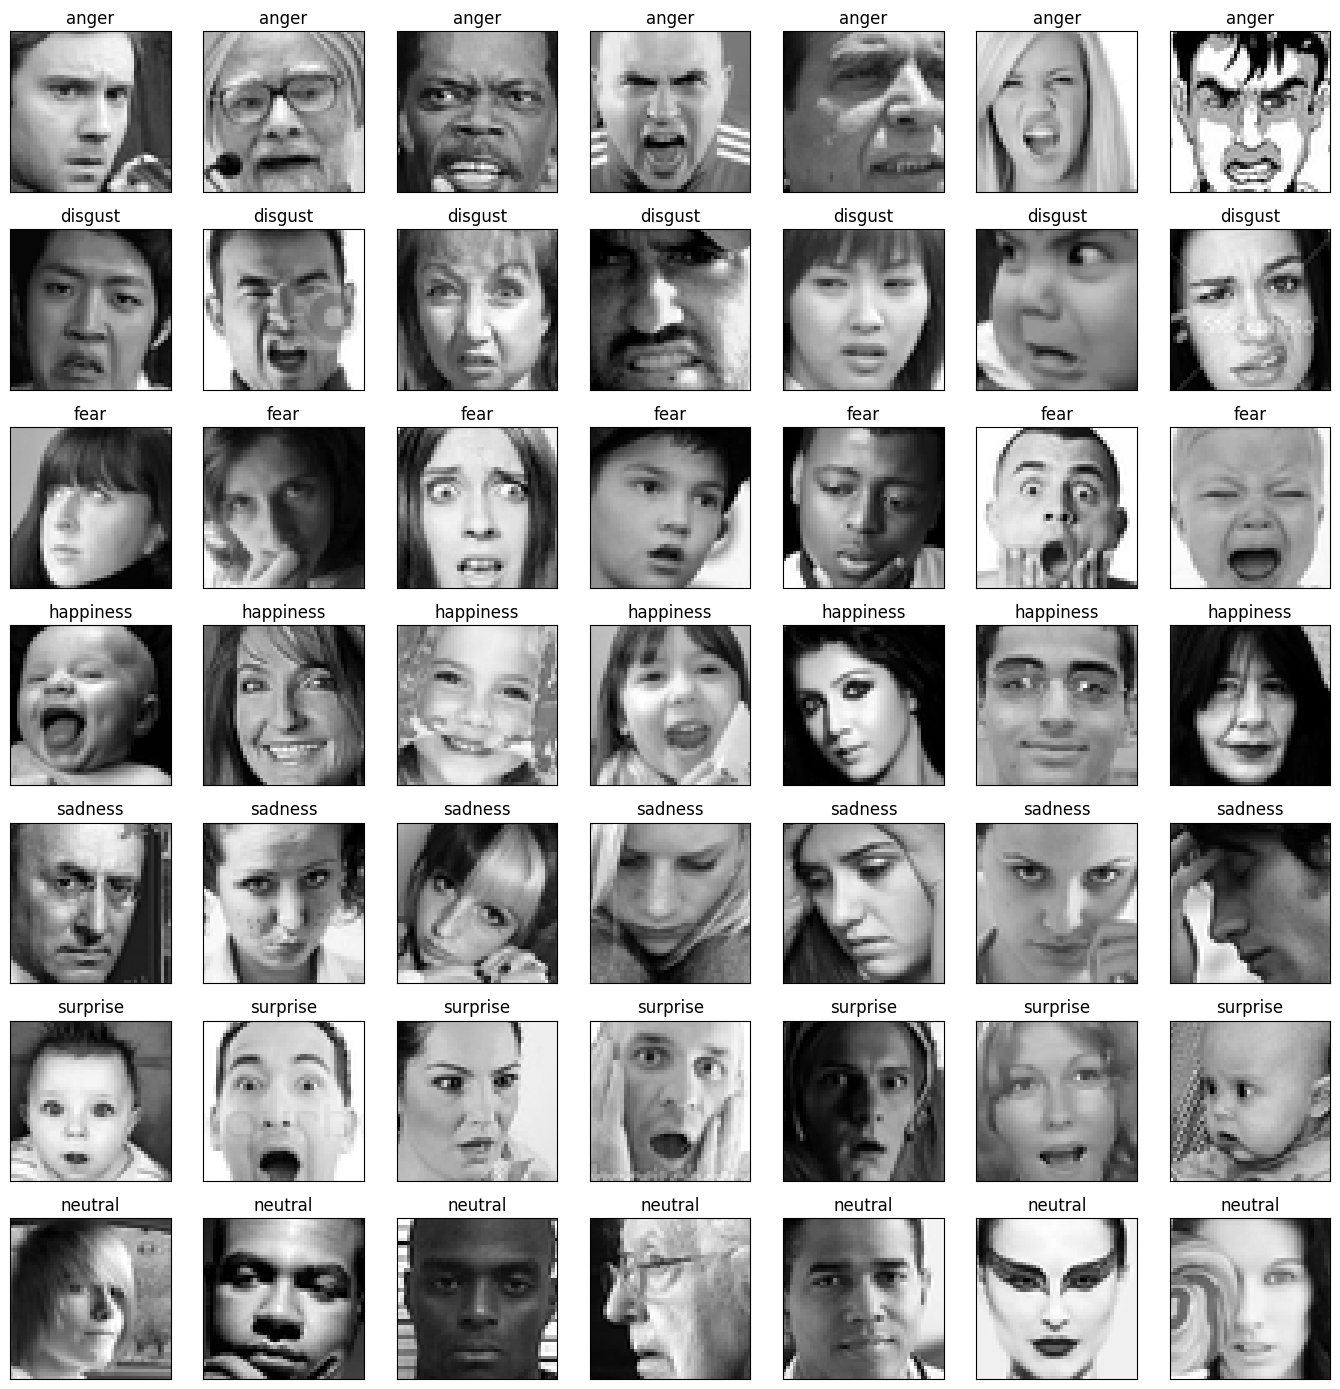

In [ ]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(21264, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:

#two callbacks are used one for early stopping to avoid overfitting and other for `ReduceLROnPlateau` for learning rate.

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 21
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.008),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/tmp/ipykernel_34/2862542063.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


598/598 [==============================] - 746s 1s/step - loss: 1.1604 - accuracy: 0.4081 - val_loss: 1.0810 - val_accuracy: 0.4565 - lr: 0.0080
Epoch 2/21
598/598 [==============================] - 748s 1s/step - loss: 1.0328 - accuracy: 0.4659 - val_loss: 1.0916 - val_accuracy: 0.3869 - lr: 0.0080
Epoch 3/21
598/598 [==============================] - 748s 1s/step - loss: 0.9265 - accuracy: 0.5442 - val_loss: 0.7573 - val_accuracy: 0.6432 - lr: 0.0080
Epoch 4/21
598/598 [==============================] - 748s 1s/step - loss: 0.8160 - accuracy: 0.6096 - val_loss: 0.8262 - val_accuracy: 0.6295 - lr: 0.0080
Epoch 5/21
598/598 [==============================] - 753s 1s/step - loss: 0.7642 - accuracy: 0.6506 - val_loss: 0.7302 - val_accuracy: 0.6700 - lr: 0.0080
Epoch 6/21
598/598 [==============================] - 748s 1s/step - loss: 0.7285 - accuracy: 0.6695 - val_loss: 0.7156 - val_accuracy: 0.6747 - lr: 0.0080
Epoch 7/21
598/598 [==============================] - 749s 1s/step - loss: 

In [ ]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
model.save("model.h5")

In [ ]:
# import keras

# with open('/content/model.yaml','r') as yaml_file:
#   yaml_savedModel = yaml_file.read()

# from keras.models import model_from_json
# trained_model=keras.models.model_from_json(yaml_savedModel)
# trained_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/model (1).h5')

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10
599/599 [==============================] - 1661s 3s/step - loss: 0.5267 - accuracy: 0.7768 - val_loss: 0.5497 - val_accuracy: 0.7692
Epoch 2/10
599/599 [==============================] - 1655s 3s/step - loss: 0.5082 - accuracy: 0.7896 - val_loss: 0.5581 - val_accuracy: 0.7724
Epoch 3/10
599/599 [==============================] - 1655s 3s/step - loss: 0.4806 - accuracy: 0.8015 - val_loss: 0.5089 - val_accuracy: 0.7833
Epoch 4/10
599/599 [==============================] - 1681s 3s/step - loss: 0.4575 - accuracy: 0.8178 - val_loss: 0.5512 - val_accuracy: 0.7809
Epoch 5/10
599/599 [==============================] - 1663s 3s/step - loss: 0.4467 - accuracy: 0.8191 - val_loss: 0.5606 - val_accuracy: 0.7772
Epoch 6/10
599/599 [==============================] - 1668s 3s/step - loss: 0.4235 - accuracy: 0.8309 - val_loss: 0.4941 - val_accuracy: 0.8021
Epoch 7/10
599/599 [==============================] - 1665s 3s/step - loss: 0.4095 - accuracy: 0.8362 - val_loss: 0.5448 - val_accuracy:

In [50]:
pd.DataFrame(history.history).reset_index().to_csv("history_facial_emotion.csv",header=True,index=False)

In [51]:
# trained_model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])
# loss,accuracy = trained_model.evaluate(X_valid,y_valid,verbose=2)
model_yaml = model.to_json()
with open("Facial_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
model.save("Facial_model.h5")

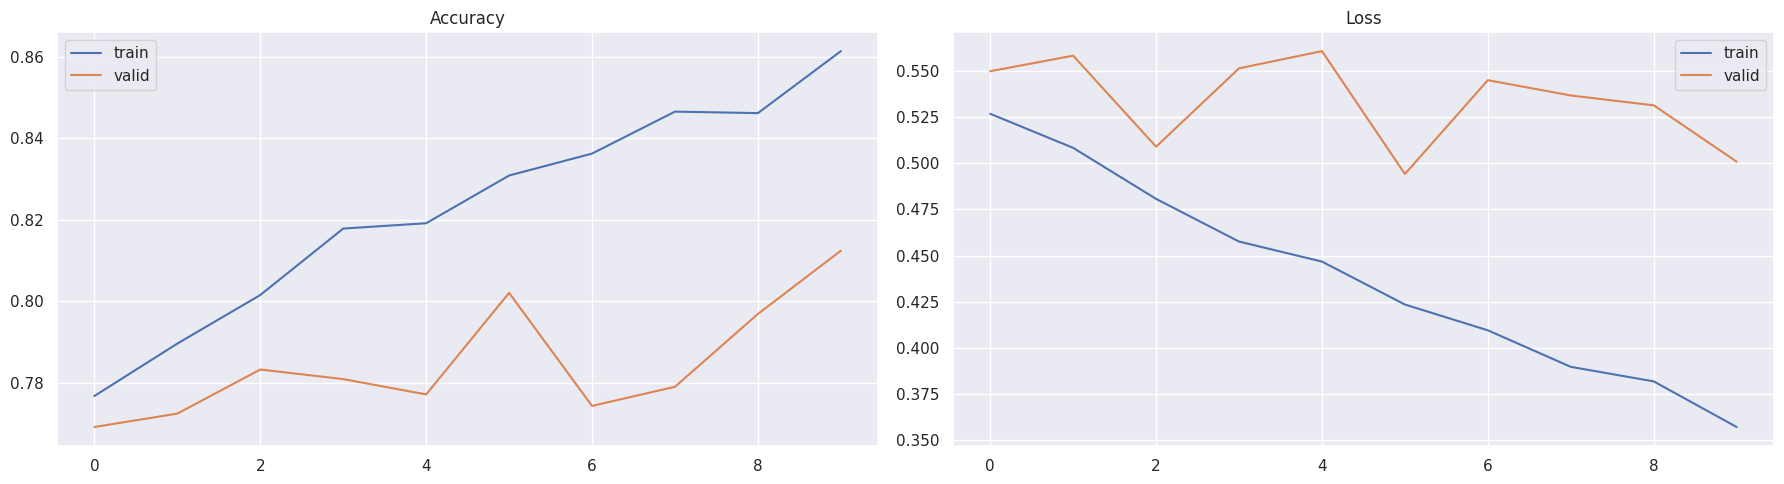

In [62]:
sns.set()
fig = pyplot.figure(0, (18,5))
ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
# pyplot.tight_layout()
ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()
pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

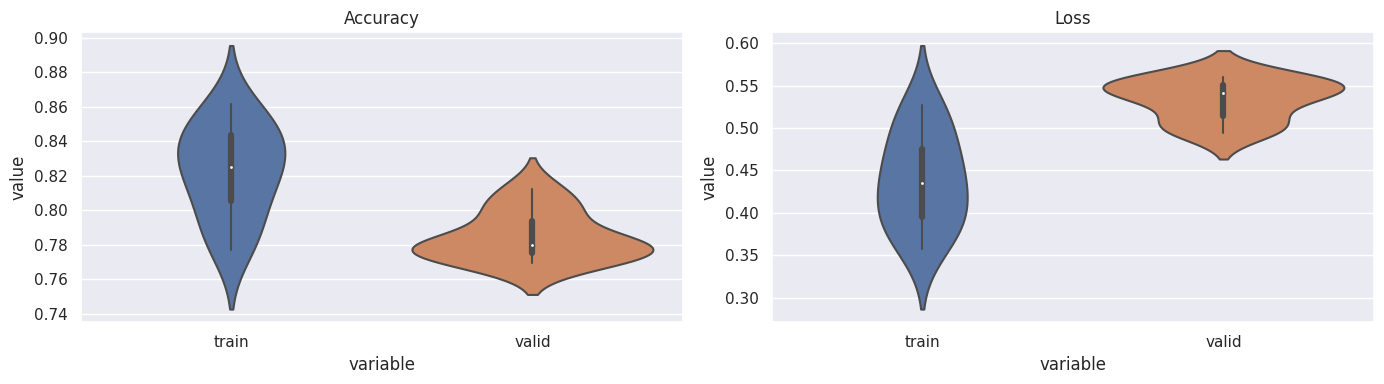

In [65]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

67/67 [==============================] - 47s 694ms/step
total wrong validation predictions: 399


              precision    recall  f1-score   support

           0       0.91      0.93      0.92       899
           1       0.71      0.78      0.74       608
           2       0.76      0.67      0.72       620

    accuracy                           0.81      2127
   macro avg       0.80      0.79      0.79      2127
weighted avg       0.81      0.81      0.81      2127



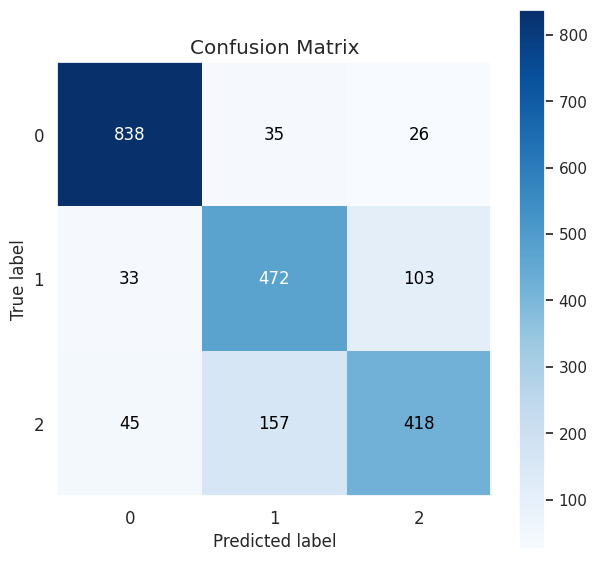

In [66]:


yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [85]:
mapper = {
    0: "+ve",
    1: "-ve",
}

1/1 [==============================] - 0s 41ms/step


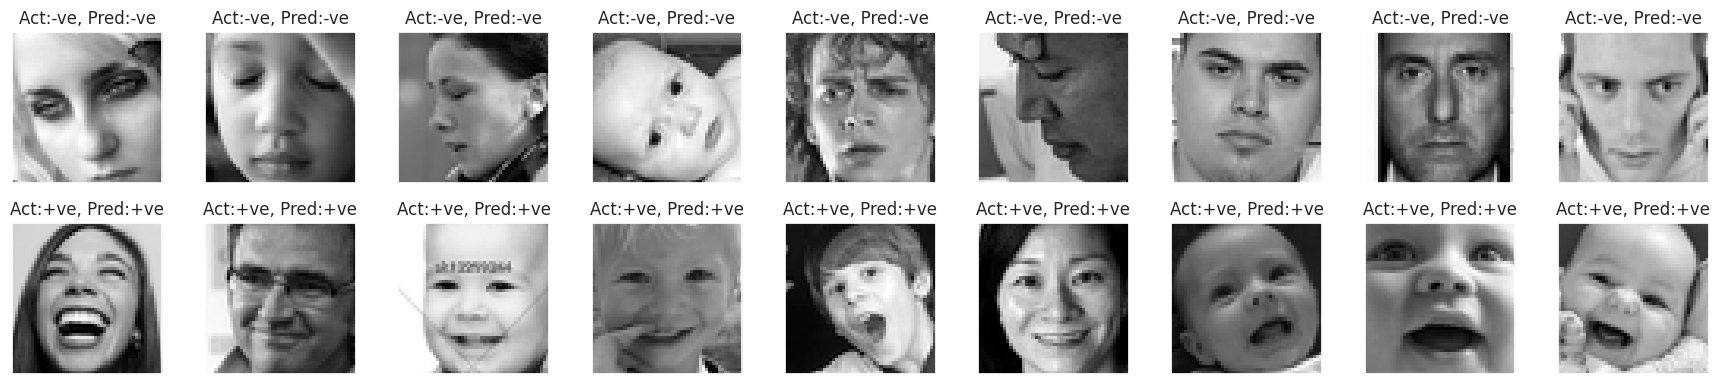

In [92]:
# np.random.seed(2)
# random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
# random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

# fig = pyplot.figure(1, (18, 4))

# for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
#         ax = pyplot.subplot(2, 9, i+1)
#         sample_img = X_valid[sadidx,:,:,0]
#         ax.imshow(sample_img, cmap='gray')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

#         ax = pyplot.subplot(2, 9, i+10)
#         sample_img = X_valid[neuidx,:,:,0]
#         ax.imshow(sample_img, cmap='gray')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

#         pyplot.tight_layout()
# df.reset_index(inplace=True)
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        pred_label = np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]
        clipped_label = np.clip(pred_label, 0, 1)
        ax.set_title(f"Act:-ve, Pred:{mapper[clipped_label]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        pred_label = np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]
        clipped_label = np.clip(pred_label, 0, 1)
        ax.set_title(f"Act:+ve, Pred:{mapper[clipped_label]}")

        pyplot.tight_layout()
